<a href="https://colab.research.google.com/github/SanjibSarkarU/colab-NN/blob/main/multi_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 24 kB/s 
     |████████████████████████████████| 462 kB 70.1 MB/s 


In [2]:
!pip install pymap3d

     |████████████████████████████████| 41 kB 334 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pymap3d: filename=pymap3d-2.7.2-py3-none-any.whl size=51818 sha256=f07b30335336f3ecc727bef8de7deaf681f300722da11122de2aca6f8c3aed49
  Stored in directory: /root/.cache/pip/wheels/b6/3f/e7/8ed2f9bc0be1c7e528c9932194d4e9350c969a2c6f2b63f15b
Successfully built pymap3d


In [3]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.models import Sequential
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as pltc
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pymap3d as pm
plt.style.use('dark_background')
colors = [k for k,v in pltc.cnames.items()]

In [4]:
df = pd.read_csv('20220222_153859_hlc.csv', skiprows=1)
df = df.rename(columns={"Latitude (Deg N)": 'lat', "Longitude (Deg W)": 'lng'}, errors="raise")
df = df.loc[(df['lat'] != 0)]
df['h'] = 0
# df.set_index([i for i in range(0, len(df.lat)-1)], inplace=True)

In [8]:
index = int(len(df.lat)/2)

In [9]:
# index

In [10]:
# df['lat'] = df['lat']-30
# df['lng'] = df['lng'] + 89

In [11]:
' Convert to local coordinate system'
index = 12224
df['e'], df['n'], df['u'] = pm.geodetic2enu(df.lat, df.lng, df.h, df.lat[index],
                                                    df.lng[index], df.h[index], ell=None, deg=True)
df.head(5)

,Date (mm/dd/yyyy),Time,Num Satellites,Position Uncertainty (m),lat,lng,Speed (kts),Heading (Deg N),Course (Deg N),OCB Temp (C),...,Volts stbd,Amps stbd,charge (%) stbd,StatorTemp (C) stbd,PCBTep (C) stbd,Error Code stbd,h,e,n,u
84,02/22/2022,15:40:32.999,8,3,30.366409,-89.622612,29.89,226.0,269.4,43.2,...,0.0,0.0,0.0,0.0,0.0,0x0,0,586.688202,1586.637310,-0.225128
85,02/22/2022,15:40:33.799,8,3,30.366408,-89.622765,28.79,225.9,269.4,43.3,...,0.0,0.0,0.0,0.0,0.0,0x0,0,571.988991,1586.537864,-0.223769
86,02/22/2022,15:40:35.999,9,3,30.366407,-89.623054,24.93,225.9,269.1,43.2,...,0.0,0.0,0.0,0.0,0.0,0x0,0,544.144988,1586.324699,-0.221282
87,02/22/2022,15:40:37.000,9,3,30.366405,-89.623188,22.74,226.2,269.4,43.3,...,0.0,0.0,0.0,0.0,0.0,0x0,0,531.277053,1586.178839,-0.220161
88,02/22/2022,15:40:37.999,9,3,30.366404,-89.623302,21.17,226.5,269.7,43.3,...,0.0,0.0,0.0,0.0,0.0,0x0,0,520.329788,1586.091841,-0.219238


In [12]:
print(f'Latitude min:{df.e.min()}, Latitude max:{df.e.max()},\nLongitude min:{df.n.min()}, Longitude max:{df.n.max()}')

Latitude min:-203.51402781846963, Latitude max:586.6882018505993,
Longitude min:-97.97658013115907, Longitude max:1586.975882221139


In [13]:
start = 10500
end = 13700
lat = df.lat[start:end]
lng = df.lng[start:end]

series_time = df.Time[start:end].to_list
series_lat = df.e[start:end]
series_lng = df.n[start:end]

# series_time = df.Time[start:end].to_list
# series_lat = df.lat[start:end]
# series_lng = df.lng[start:end]

coordinates = [[i,j] for i,j in zip(series_lat, series_lng)]
coordinates= np.array(coordinates)
# print(coordinates[:10])

In [14]:
# 'Compare before and after local converstion'
# ' Back to lag lng'
# df['back_lat'], df['back_lng'], _ = pm.enu2geodetic(df.e, df.n, df.u, df.lat[84],
#                                                     df.lng[84], df.h[84], ell=None, deg=True)

In [15]:
# df.head(5)

In [16]:
# type(coordinates)

In [17]:
def ts_data_preparation(features, window=5, future=1, batch=1, shuffle=False):
    target = features[(future - 1):]
    features = features[:-(future - 1)] if future != 1 else features
    tensor = TimeseriesGenerator(features, target, length=window, batch_size=batch, shuffle=shuffle)
    return tensor

In [18]:
def test_data_preparation(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [19]:
def train_test_split(dataset, percentage):
    train_size = int(len(dataset) * percentage)
    # test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [20]:
# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(coordinates)
# apply transform
coordinates = scaler.transform(coordinates)

In [21]:
# coordinates[0:10]

In [22]:
# # inverse transform
# inverse = scaler.inverse_transform(coordinates)
# inverse[:10]

In [23]:
train_coor, test_coor = train_test_split(coordinates, 0.7)

In [24]:
# train_coor[:10]  #.shape, test_coor.shape

In [25]:
window_size = 20
future = 1
batch_size = 32

In [26]:
train_coor = ts_data_preparation(train_coor, window=window_size, future=future, batch=batch_size, shuffle=True)

In [27]:
# train_coor[1]

In [28]:
def model_lstm(w_size):
    units = 64
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units, activation='relu', return_sequences=True, input_shape=(w_size, 2)),
        tf.keras.layers.LSTM(units, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear')])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0002, momentum=0.9),
                  loss='mse')
    model.summary()
    return model

In [29]:
model = model_lstm(window_size)

epochs = 120

model.fit(train_coor, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 50,306
Trainable params: 50,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
70/70 [==============================] - 4s 26ms/step - loss: 0.8367
Epoch 2/120
70/70 [==============================] - 2s 26ms/step - loss: 0.7826
Epoch 3/120
70/70 [==============================] - 2s 26ms/step - loss: 0.6457
Epoch 4/120
70/70 [==============================] - 2s 26ms/step - loss:

In [30]:
test_coor = test_data_preparation(coordinates, window_size=window_size, batch_size=batch_size)

In [31]:
# for example in test_coor:
#   print(example[0].numpy())
#   print(example[1].numpy())
#   break

In [32]:
predicted_coor = model.predict(test_coor)

In [33]:
type(predicted_coor)

numpy.ndarray

In [34]:
# inverse transform
predicted_coor = scaler.inverse_transform(predicted_coor)

In [35]:
df_n = pd.DataFrame(predicted_coor, columns=('p_lat', 'p_lng'))
df_n['h'] = 0

In [36]:
# df_n['p_lat'] = df_n['p_lat']+30
# df_n['p_lng'] = df_n['p_lng']-89

In [37]:
# df_n.head(10)

In [38]:
# plt.plot(df_n['p_lng'], df_n['p_lat'], color='r')


In [40]:
len(df.lat)

24448

In [41]:
' Back to lag lng'
df_n['Predted_lat'], df_n['Predicted_lng'], _ = pm.enu2geodetic(df_n.p_lat, df_n.p_lng, df_n.h,
                                                                                  df.lat[index], df.lng[index],
                                                                                  df.h[index], ell=None, deg=True)

In [ ]:
df_n.head(5)

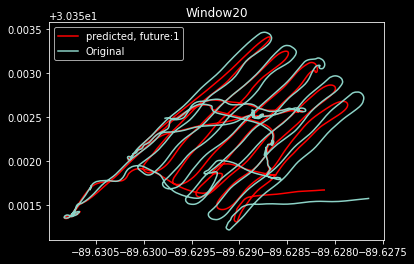

In [42]:
plt.plot(df_n.Predicted_lng, df_n.Predted_lat, color='r', label=f'predicted, future:{future}')
plt.plot(lng, lat, label='Original')
plt.title(f'Window{window_size}')
plt.legend()
plt.show()

In [ ]:
# plt.plot(lng, lat, label='y')

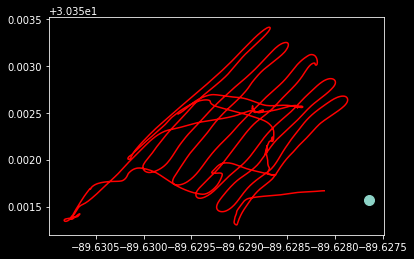

In [43]:
plt.plot(df_n.Predicted_lng, df_n.Predted_lat, color='r', label=f'predicted, future:{future}')
plt.scatter(lng.iloc[len(lng)-1], lat.iloc[len(lng)-1], s=100)